<a href="https://colab.research.google.com/github/Codechickdev/ML_Projects/blob/main/deeplearning_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Final Project

## Reference
- [Dataset Link](https://www.kaggle.com/datasets/hadiepratamatulili/anime-vs-cartoon-vs-human)


## Problem Statement

- Given a dataset contains images `Anime`, `Human`, `Cartoon`, and we are asked to classify into those three categoriesa
- It's a `Classification` Problem.
- Given Dataset is `Images`

## Solution
- By using `Pytorch's Neural Networks`

### Step - 1 Prepare Notebook

For download dataset from kaggle, we can use opendatasets library and for 

In [1]:
!pip install opendatasets jovian --quiet --upgrade

     |████████████████████████████████| 68 kB 7.1 MB/s 


In [2]:
import os
import numpy as np
import opendatasets as od

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Step - 2 Download Dataset

In [3]:
DATASET_URL = 'https://www.kaggle.com/datasets/hadiepratamatulili/anime-vs-cartoon-vs-human'
od.download(DATASET_URL)

100%|██████████| 3.95G/3.95G [03:30<00:00, 20.1MB/s]


Let's take and look at the parent directory which we had download

In [4]:
PARENT_DIR = '/content/anime-vs-cartoon-vs-human/Data'

os.listdir(PARENT_DIR)

['human', 'cartoon', 'anime']

We have images seperated into folders. Let's find the sizes of each folders

In [5]:
for i in os.listdir(PARENT_DIR):
    print(f"Folder {i} with Size {len(os.listdir(PARENT_DIR + '/' + i))}")

Folder human with Size 3000
Folder cartoon with Size 2913
Folder anime with Size 3004


### Step - 3 Explore Dataset

Let's look again and explore our dataset

In [6]:
from PIL import Image
import random

def plotRawImage(DATA_DIR, num):
    """
    Function to plot raw images from the directory
    """
    size = len(DATA_DIR)
    data = os.listdir(DATA_DIR)
    img = Image.open(DATA_DIR + '/' + data[num])
    print(f'Image Size: {img.size}')
    return img

Image Size: (53, 53)


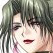

In [7]:
plotRawImage('/content/anime-vs-cartoon-vs-human/Data/anime', 5)

Image Size: (318, 159)


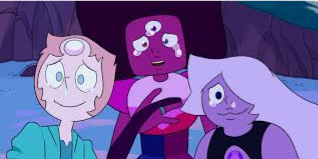

In [8]:
plotRawImage('/content/anime-vs-cartoon-vs-human/Data/cartoon', 556)

On Exploring, we came to know that each image has it's `own size`. We can re-size all images in specific size, which makes computation easy

### Step - 4 Load and Preprocess Dataset

We can use various `pytorch's` class like `ImageFolder`, `Dataset` and some `transform` functions.

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

In [10]:
sampleDataset = ImageFolder(PARENT_DIR)
"Total Length of Dataset :", len(sampleDataset)

('Total Length of Dataset :', 8917)

In [11]:
classes = sampleDataset.classes
classes

['anime', 'cartoon', 'human']

In [12]:
sampleDataset = ImageFolder(PARENT_DIR, transform = tt.ToTensor()) # Changes from pixel to tensor

In [13]:
for img, _ in sampleDataset:
    print(img.size())
    break

torch.Size([3, 63, 63])


In [14]:
img, _ = sampleDataset[848]
print(img.size())

torch.Size([3, 88, 88])


In [15]:
img, _ = sampleDataset[8448]
print(img.size())

torch.Size([3, 1024, 1024])


Now if you look back, we have images varying from size to size, Let's `resize` every image and add some `agumentation` to the images to avoid `overfitting`

In [16]:
# Changing to Tensor and Applying Data Agumentation

dataFolder = ImageFolder(
    PARENT_DIR,
    tt.Compose([
        tt.Resize(64), # Resize to 3x64x64
        tt.RandomCrop(32, pad_if_needed = True), # Cropping Half Image
        tt.RandomRotation(degrees = 55),
        tt.ToTensor()
    ])
)

In [17]:
for i in [4, 44, 444, 4444]:
    img, _ = dataFolder[i]
    print(f"Image Shape: {img.size()}")

Image Shape: torch.Size([3, 32, 32])
Image Shape: torch.Size([3, 32, 32])
Image Shape: torch.Size([3, 32, 32])
Image Shape: torch.Size([3, 32, 32])


In [18]:
def plotTensor(num):
    """Plot Tensors after Image Augmentation"""
    img, _ = dataFolder[num]
    plt.imshow(img.permute((1, 2, 0)))
    plt.show()

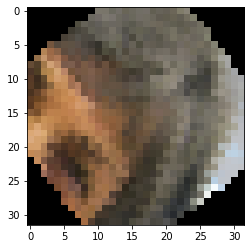

In [19]:
plotTensor(7654)

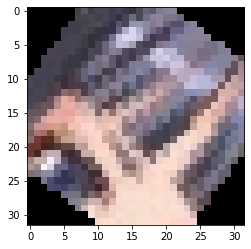

In [20]:
plotTensor(76)

As we see, Our Dataset is at final stage, Just splitting for traning and validation is left, Our Model will not like to overfit but `DataAugmentation` and `Validating`.
Let's split the dataset. We need only `2%` of the original dataset for validation

In [21]:
valFrac = 0.2
valLength = int(valFrac * len(dataFolder))

trainLength = len(dataFolder) - valLength

trainLength, valLength

(7134, 1783)

In [22]:
train_ds, val_ds = random_split(dataFolder, [trainLength, valLength])

len(train_ds), len(val_ds)

(7134, 1783)

and Now let's create a `DataLoader` with **128** batches with Pytorch

In [23]:
batchSize = 128

train_dl = DataLoader(
    train_ds, 
    batch_size = batchSize,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

val_dl = DataLoader(
    val_ds, 
    batch_size = batchSize,
    num_workers = 4,
    pin_memory = True
)

We saw as seperate Images, Let's vizualize as batches

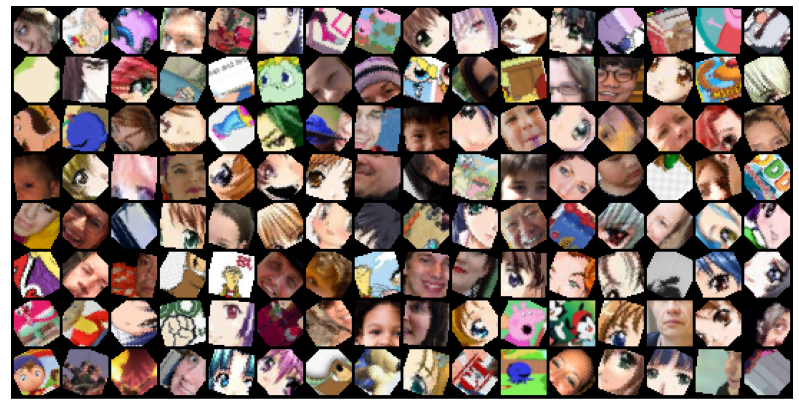

In [24]:
def plotBatch(dataLoader):
    """Function to Plot as Batch"""
    for images, label in dataLoader:
        fig, ax = plt.subplots(figsize = (14, 8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
        break
    
plotBatch(train_dl)

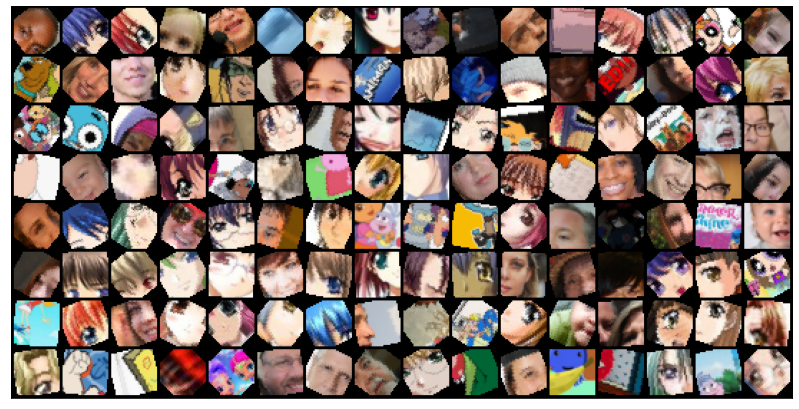

In [25]:
plotBatch(val_dl)

### Step - 5 Config GPU

In this step we setup our code that can even run on `GPU/CUDA` if available

In [26]:
def getDevice():
    # Function to Get Default Device
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def transferToDevice(data, device):
    """
    Function to transfer Model and DataLoader to GPU
    """
    if isinstance(data, (list, tuple)):
        return [transferToDevice(x, device) for x in data]
    return data.to(device, non_blocking = True)


class DeviceDataLoader():
    def __init__(self, dataLoader, device):
        self.dataLoader = dataLoader
        self.device = device
    
    def __iter__(self):
        for b in self.dataLoader:
            yield transferToDevice(b, self.device)
        
    def __len__(self):
        return len(self.dataLoader)

We created config functions and classes, Let's test it
1. By checking if gpu is available
2. By Changing the images from the data loader

In [27]:
defaultDevice = getDevice()
defaultDevice

device(type='cuda')

In [28]:
for images, _ in train_dl:
    print(f"Device Before: {images.device}")
    configedImage = transferToDevice(images, defaultDevice)
    print(f"Device After: {configedImage.device}")
    break

Device Before: cpu
Device After: cuda:0


We transfered Sample Tensor from CPU to Cuda. Now let's change the whole DataLoader

In [29]:
train_dl = DeviceDataLoader(train_dl, defaultDevice)
val_dl = DeviceDataLoader(val_dl, defaultDevice)

In [30]:
train_dl.device, val_dl.device

(device(type='cuda'), device(type='cuda'))

### Step - 6 Model Traning

We will use `Convoluation Neural Network`.

In [31]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1, stride = 1),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, xb):
        out = self.network(xb)
        return out

In [32]:
for images, labels in train_dl:
    model = CNN_Model().to(defaultDevice)
    print(images.shape)
    out = model(images)
    print(out.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 3])


We changed the dimension from `3 Channel` RGB image with 32 * 32 Width and Height, Now we have three output neurons which outputs the three probability.

In [33]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [34]:
def val_step(model, dataloader, loss_fn):
    model.eval() 
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            val_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            val_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [39]:
def train(model,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs = 5):
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
    return results

In [40]:
cnnModel = CNN_Model().to(defaultDevice)

In [41]:
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnnModel.parameters(), lr=0.001)

In [42]:
cnnModelResults = train(model = cnnModel, 
                        train_dataloader = train_dl,
                        test_dataloader = val_dl,
                        optimizer = optimizer,
                        loss_fn = loss_fn, 
                        epochs = epochs)

Epoch: 1 | train_loss: 0.8258 | train_acc: 0.6073 | val_loss: 0.5504 | val_acc: 0.7822
Epoch: 2 | train_loss: 0.5346 | train_acc: 0.7911 | val_loss: 0.4577 | val_acc: 0.8178
Epoch: 3 | train_loss: 0.4297 | train_acc: 0.8376 | val_loss: 0.3883 | val_acc: 0.8571
Epoch: 4 | train_loss: 0.3639 | train_acc: 0.8669 | val_loss: 0.2824 | val_acc: 0.8958
Epoch: 5 | train_loss: 0.3373 | train_acc: 0.8749 | val_loss: 0.3266 | val_acc: 0.8846


In [77]:
def showResults(results, accuracy = True):
    if accuracy:
        plt.plot(results['train_acc'])
        plt.plot(results['val_acc'])
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['Traning', 'Validation'])
        plt.show()
    else:
        plt.plot(results['train_loss'])
        plt.plot(results['val_loss'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['Traning', 'Validation'])
        plt.show()

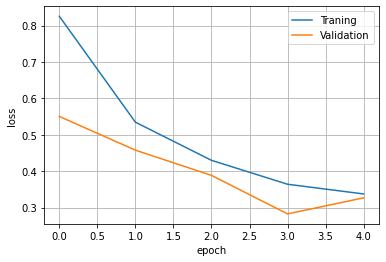

In [79]:
showResults(cnnModelResults, accuracy = False) # Loss Plot

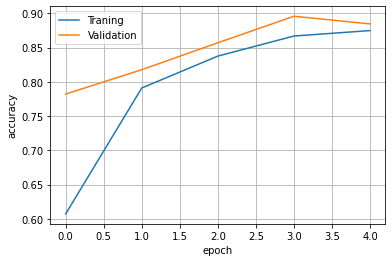

In [80]:
showResults(cnnModelResults, accuracy = True) # Accuracy Plot

In [69]:
results = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
results

{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [70]:
results['train_loss'] += cnnModelResults['train_loss']
results['train_acc'] += cnnModelResults['train_acc']
results['val_loss'] += cnnModelResults['val_loss']
results['val_acc'] += cnnModelResults['val_acc']

In [72]:
%%time

cnnModelResults_2 = train(model = cnnModel, 
                        train_dataloader = train_dl,
                        test_dataloader = val_dl,
                        optimizer = optimizer,
                        loss_fn = loss_fn, 
                        epochs = 10)

Epoch: 1 | train_loss: 0.2851 | train_acc: 0.8977 | val_loss: 0.2583 | val_acc: 0.9036
Epoch: 2 | train_loss: 0.2572 | train_acc: 0.9091 | val_loss: 0.2773 | val_acc: 0.9024
Epoch: 3 | train_loss: 0.2476 | train_acc: 0.9131 | val_loss: 0.2256 | val_acc: 0.9142
Epoch: 4 | train_loss: 0.2463 | train_acc: 0.9146 | val_loss: 0.2994 | val_acc: 0.8866
Epoch: 5 | train_loss: 0.2407 | train_acc: 0.9110 | val_loss: 0.1918 | val_acc: 0.9300
Epoch: 6 | train_loss: 0.2052 | train_acc: 0.9274 | val_loss: 0.2288 | val_acc: 0.9258
Epoch: 7 | train_loss: 0.2045 | train_acc: 0.9242 | val_loss: 0.2568 | val_acc: 0.9024
Epoch: 8 | train_loss: 0.1898 | train_acc: 0.9326 | val_loss: 0.1947 | val_acc: 0.9261
Epoch: 9 | train_loss: 0.1903 | train_acc: 0.9365 | val_loss: 0.1882 | val_acc: 0.9350
Epoch: 10 | train_loss: 0.1709 | train_acc: 0.9402 | val_loss: 0.1543 | val_acc: 0.9462
CPU times: user 17.5 s, sys: 4.09 s, total: 21.6 s
Wall time: 18min 28s


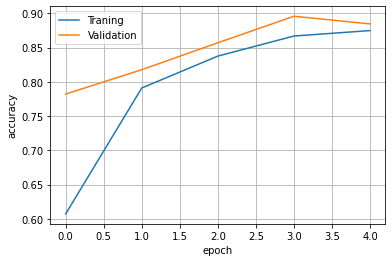

In [73]:
showResults(cnnModelResults_2, accuracy = True)

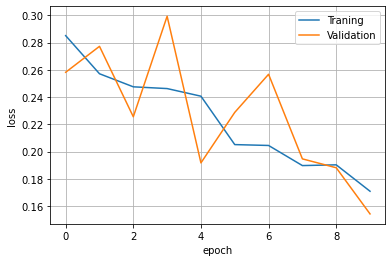

In [81]:
showResults(cnnModelResults_2, accuracy = False)

As our epochs increasing, our time increases as well as out `accuracy`. We can see there's constant change in validation loss. This is because we have to tune the `Hyperparameter` to avoid overfitting. But this is ok for a average model. Now we can test our model with Single Sample

### Step - 7 Testing Prediction

In [82]:
def predict_image(img, model, classes):
    xb = transferToDevice(img.unsqueeze(0), defaultDevice)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

In [87]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataFolder.classes)
    print('Target:', dataFolder.classes[label])
    print('Prediction:', pred)

Target: human
Prediction: human


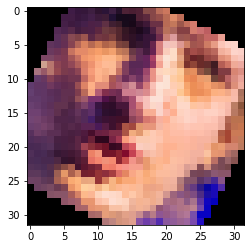

In [89]:
show_image_prediction(*val_ds[541])

Target: human
Prediction: human


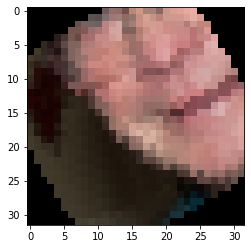

In [91]:
show_image_prediction(*val_ds[908])

### Step - 8 Recording HyperParameter and Saving weights

In [94]:
for param_tensor in model.state_dict(): # Model Weights
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

network.0.weight 	 torch.Size([32, 3, 3, 3])
network.0.bias 	 torch.Size([32])
network.2.weight 	 torch.Size([64, 32, 3, 3])
network.2.bias 	 torch.Size([64])
network.5.weight 	 torch.Size([128, 64, 3, 3])
network.5.bias 	 torch.Size([128])
network.7.weight 	 torch.Size([128, 128, 3, 3])
network.7.bias 	 torch.Size([128])
network.10.weight 	 torch.Size([256, 128, 3, 3])
network.10.bias 	 torch.Size([256])
network.12.weight 	 torch.Size([512, 16384])
network.12.bias 	 torch.Size([512])
network.14.weight 	 torch.Size([3, 512])
network.14.bias 	 torch.Size([3])


In [111]:
os.makedirs('models')

In [112]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, "./models/CNN_Model")

In [92]:
import jovian

In [93]:
jovian.reset()

In [116]:
jovian.log_hyperparams(batch_size = 128, 
                       arch = 'CNN_Model', 
                       epochs = [5, 10], 
                       lrs = 0.01,
                       opt = 'Adam')

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [118]:
results['train_loss'] += cnnModelResults_2['train_loss']
results['train_acc'] += cnnModelResults_2['train_acc']
results['val_loss'] += cnnModelResults_2['val_loss']
results['val_acc'] += cnnModelResults_2['val_acc']

In [120]:
min(results['train_loss']), max(results['train_acc'])

(0.1709427908062935, 0.9402159716945289)

In [122]:
jovian.log_metrics(train_loss = min(results['train_loss']),
                   train_acc = max(results['train_acc']),
                   val_loss = min(results['val_loss']),
                   val_acc = max(results['val_acc']))

[jovian] Metrics logged.


In [123]:
jovian.commit(project = 'Deep Learning Course Project', 
              outputs = '/content/models/CNN_Model', 
              environment = None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Conclusion

1. We have found a problem in deep learning and try to solve it using Pytorch's and some Neural Network Knowledge.
2. Logging HyperParameter, So that we can make a model that beats this accuracy and have low loss than this `CNN_Model`.
3. We can compare the performance by just loading the save model and predict each by each.
4. We came `overfitting` problem by just **rotating, croping and resizing** the images.

In [124]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
